In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy



C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
#at_eur_1h = pd.read_csv('data/indicators_eurusd_1h.csv')

In [3]:
data = pd.read_csv('data/indicators_eurusd_d.csv')
data

,Date,Open,High,Low,Close,Name,Return,Up,Down,avg_14up,...,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL
0,2020-01-29,1.10220,1.10277,1.09926,1.10105,EURUSD,-0.001044,0.000000,0.001044,0.000463,...,1.106465,1.110141,-0.003676,1.09926,1.11713,10.016788,-89.983212,1.110335,1.121102,1.099567
1,2020-01-30,1.10103,1.10396,1.10076,1.10341,EURUSD,0.002141,0.002141,0.000000,0.000518,...,1.105995,1.109642,-0.003647,1.09926,1.11713,23.223279,-76.776721,1.109646,1.120332,1.098960
2,2020-01-31,1.10336,1.10916,1.10171,1.10903,EURUSD,0.005080,0.005080,0.000000,0.000792,...,1.106462,1.109597,-0.003135,1.09926,1.11713,54.672636,-45.327364,1.109289,1.119524,1.099054
3,2020-02-03,1.10859,1.10908,1.10369,1.10594,EURUSD,-0.002790,0.000000,0.002790,0.000792,...,1.106382,1.109326,-0.002944,1.09926,1.11713,37.381086,-62.618914,1.108607,1.117710,1.099504
4,2020-02-04,1.10593,1.10641,1.10332,1.10452,EURUSD,-0.001285,0.000000,0.001285,0.000636,...,1.106095,1.108970,-0.002875,1.09926,1.11713,29.434807,-70.565193,1.108094,1.116884,1.099304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,2023-12-25,1.10175,1.10255,1.10121,1.10150,EURUSD,0.000209,0.000209,0.000000,0.002714,...,1.094173,1.088813,0.005360,1.07246,1.10402,92.015209,-7.984791,1.089533,1.107951,1.071115
1012,2023-12-26,1.10144,1.10456,1.10089,1.10415,EURUSD,0.002403,0.002403,0.000000,0.002885,...,1.095708,1.089949,0.005759,1.07246,1.10456,98.722741,-1.277259,1.089771,1.108839,1.070704
1013,2023-12-27,1.10418,1.11226,1.10288,1.11060,EURUSD,0.005825,0.005825,0.000000,0.003135,...,1.097999,1.091479,0.006520,1.07246,1.11226,95.829146,-4.170854,1.090442,1.111451,1.069432
1014,2023-12-28,1.11059,1.11395,1.10554,1.10623,EURUSD,-0.003943,0.000000,0.003943,0.003135,...,1.099265,1.092572,0.006694,1.07418,1.11395,80.588383,-19.411617,1.091294,1.113440,1.069148


### =====================
[Simpful on github](https://github.com/aresio/simpful/blob/master/simpful/simpful.py)
### =====================

## RSI decision

In [4]:
def decision_rsi(df):
    df['dec_rsi'] = 'HOLD'  

    df.loc[df['RSI'] < 30, 'dec_rsi'] = 'BUY'
    df.loc[df['RSI'] > 70, 'dec_rsi'] = 'SELL'

    return df

In [5]:
decision_rsi(data)
data['dec_rsi'].value_counts()

dec_rsi
HOLD    767
BUY     131
SELL    118
Name: count, dtype: int64

In [6]:
#########
at_eur_1h = data
#########

In [7]:
FS = sf.FuzzySystem()


# linguistic variable for the input
S1 = sf.FuzzySet(points=[[0, 1.], [30, 1.], [50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[50, 1.], [51, 1.], [61, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[61, 0.], [70, 1.], [100, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 100])
FS.add_linguistic_variable("RSI", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_RSI_fuzz_system", LV)


R1 = "IF (RSI IS low) THEN (Signal_RSI_fuzz_system IS SELL)"
R2 = "IF (RSI IS medium) THEN (Signal_RSI_fuzz_system IS HOLD)"
R3 = "IF (RSI IS high) THEN (Signal_RSI_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

at_eur_1h['Signal_RSI_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['RSI']):
    FS.set_variable("RSI", value)
    decision = FS.Mamdani_inference()['Signal_RSI_fuzz_system']
    
    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'BUY'



  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



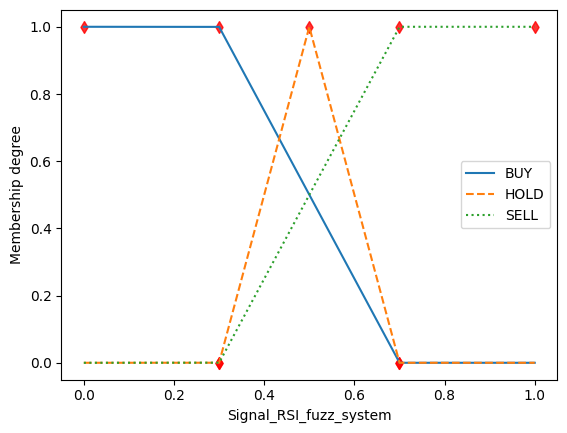

In [8]:
FS.plot_variable('Signal_RSI_fuzz_system')

In [9]:
at_eur_1h['Signal_RSI_fuzz_system'].value_counts()

Signal_RSI_fuzz_system
HOLD    699
SELL    175
BUY     142
Name: count, dtype: int64

# Backtesting

### ========

[Backtesting on github](https://github.com/kernc/backtesting.py/blob/master/backtesting/backtesting.py#L1014)
### ========

## Fuzzy

In [10]:
# zmiana decyzji na -1, 0, 1
at_eur_1h['Signal_RSI_fuzz_system'] = at_eur_1h['Signal_RSI_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


# zmiana na datę i ustaw jako index
at_eur_1h = at_eur_1h.set_index(pd.DatetimeIndex(at_eur_1h['Date']))


In [11]:
print(at_eur_1h['Signal_RSI_fuzz_system'].value_counts())

Signal_RSI_fuzz_system
 0    699
-1    175
 1    142
Name: count, dtype: int64


In [12]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        
        self.set_signal(at_eur_1h['Signal_RSI_fuzz_system'])
      
    
    #    size = 0.5  
     #   if self.set_signal == 1:
      #      self.buy(size=size)
       # elif self.set_signal == -1:
        #    self.sell(size=size)
       # super().next()
        
# dodać warunki zmieniające size
# set signal dodac rozmiar wejscia
bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2020-01-29 00:00:00
End                       2023-12-29 00:00:00
Duration                   1430 days 00:00:00
Exposure Time [%]                   99.409449
Equity Final [$]                  9999.288171
Equity Peak [$]                  10000.012913
Return [%]                          -0.007118
Buy & Hold Return [%]                0.277008
Return (Ann.) [%]                   -0.001766
Volatility (Ann.) [%]                0.000861
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.007486
Avg. Drawdown [%]                    -0.00402
Max. Drawdown Duration     1380 days 00:00:00
Avg. Drawdown Duration      712 days 00:00:00
# Trades                                  315
Win Rate [%]                        28.888889
Best Trade [%]                        4.85282
Worst Trade [%]                     -3.851114
Avg. Trade [%]                    

## Sharp

In [13]:
# zmiana decyzji na -1, 0, 1
at_eur_1h['dec_rsi'] = at_eur_1h['dec_rsi'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

In [15]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['dec_rsi'])

bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2020-01-29 00:00:00
End                       2023-12-29 00:00:00
Duration                   1430 days 00:00:00
Exposure Time [%]                   99.409449
Equity Final [$]                  9999.400799
Equity Peak [$]                  10000.015148
Return [%]                          -0.005992
Buy & Hold Return [%]                0.277008
Return (Ann.) [%]                   -0.001486
Volatility (Ann.) [%]                0.000863
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.006578
Avg. Drawdown [%]                   -0.003566
Max. Drawdown Duration     1380 days 00:00:00
Avg. Drawdown Duration      712 days 00:00:00
# Trades                                  247
Win Rate [%]                        27.935223
Best Trade [%]                       8.107046
Worst Trade [%]                     -3.307153
Avg. Trade [%]                    

# Williams %R ('r_percent')

In [20]:
at_eur_1h.head()

,Date,Open,High,Low,Close,Name,Return,Up,Down,avg_14up,...,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL,dec_rsi,Signal_RSI_fuzz_system
2020-01-29,2020-01-29,1.10220,1.10277,1.09926,1.10105,EURUSD,-0.001044,0.000000,0.001044,0.000463,...,-0.003676,1.09926,1.11713,10.016788,-89.983212,1.110335,1.121102,1.099567,BUY,1
2020-01-30,2020-01-30,1.10103,1.10396,1.10076,1.10341,EURUSD,0.002141,0.002141,0.000000,0.000518,...,-0.003647,1.09926,1.11713,23.223279,-76.776721,1.109646,1.120332,1.098960,HOLD,0
2020-01-31,2020-01-31,1.10336,1.10916,1.10171,1.10903,EURUSD,0.005080,0.005080,0.000000,0.000792,...,-0.003135,1.09926,1.11713,54.672636,-45.327364,1.109289,1.119524,1.099054,HOLD,0
2020-02-03,2020-02-03,1.10859,1.10908,1.10369,1.10594,EURUSD,-0.002790,0.000000,0.002790,0.000792,...,-0.002944,1.09926,1.11713,37.381086,-62.618914,1.108607,1.117710,1.099504,HOLD,0
2020-02-04,2020-02-04,1.10593,1.10641,1.10332,1.10452,EURUSD,-0.001285,0.000000,0.001285,0.000636,...,-0.002875,1.09926,1.11713,29.434807,-70.565193,1.108094,1.116884,1.099304,HOLD,0


In [22]:
at_eur_1h.r_percent.describe()

count    1016.000000
mean      -51.222510
std        30.857908
min       -99.632893
25%       -80.543695
50%       -52.313038
75%       -23.217639
max        -0.065725
Name: r_percent, dtype: float64

In [21]:
def decision_williams(df):
    df['dec_will'] = 'HOLD'  

    df.loc[df['r_percent'] < -80, 'dec_will'] = 'BUY'
    df.loc[df['r_percent'] > -20, 'dec_will'] = 'SELL'

    return df



In [22]:
decision_williams(at_eur_1h)
at_eur_1h['dec_will'].value_counts()

dec_will
HOLD    530
BUY     257
SELL    229
Name: count, dtype: int64

In [23]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-100, 1.], [-80, 1.], [-50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-50, 1.], [-49, 1.], [-39, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[-39, 0.], [-20, 1.], [0, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-100, 0])
FS.add_linguistic_variable("r_percent", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_william_fuzz_system", LV)


R1 = "IF (r_percent IS low) THEN (Signal_william_fuzz_system IS SELL)"
R2 = "IF (r_percent IS medium) THEN (Signal_william_fuzz_system IS HOLD)"
R3 = "IF (r_percent IS high) THEN (Signal_william_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

at_eur_1h['Signal_william_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['r_percent']):
    FS.set_variable("r_percent", value)
    decision = FS.Mamdani_inference()['Signal_william_fuzz_system']
    
    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_william_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_william_fuzz_system'] = 'BUY'



  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



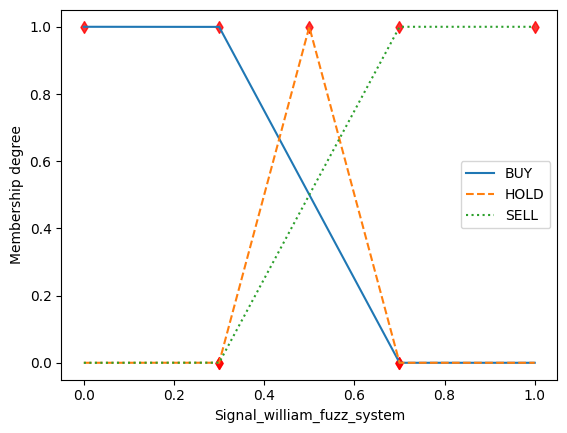

In [24]:
FS.plot_variable('Signal_william_fuzz_system')

In [25]:
at_eur_1h['Signal_william_fuzz_system'].value_counts()

Signal_william_fuzz_system
HOLD    441
SELL    307
BUY     268
Name: count, dtype: int64

# Backtesting

In [26]:
# zmiana decyzji na -1, 0, 1
at_eur_1h['Signal_william_fuzz_system'] = at_eur_1h['Signal_william_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


## Fuzzy

In [27]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['Signal_william_fuzz_system'])

bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2020-01-29 00:00:00
End                       2023-12-29 00:00:00
Duration                   1430 days 00:00:00
Exposure Time [%]                   99.409449
Equity Final [$]                   9998.55529
Equity Peak [$]                       10000.0
Return [%]                          -0.014447
Buy & Hold Return [%]                0.277008
Return (Ann.) [%]                   -0.003584
Volatility (Ann.) [%]                0.000861
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.014447
Avg. Drawdown [%]                   -0.014447
Max. Drawdown Duration     1423 days 00:00:00
Avg. Drawdown Duration     1423 days 00:00:00
# Trades                                  573
Win Rate [%]                        23.036649
Best Trade [%]                         3.8388
Worst Trade [%]                     -2.655819
Avg. Trade [%]                    

## Sharp

In [28]:
at_eur_1h['dec_will'] = at_eur_1h['dec_will'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['dec_will'])

bt = Backtest(at_eur_1h, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2020-01-29 00:00:00
End                       2023-12-29 00:00:00
Duration                   1430 days 00:00:00
Exposure Time [%]                   99.409449
Equity Final [$]                  9998.763934
Equity Peak [$]                       10000.0
Return [%]                          -0.012361
Buy & Hold Return [%]                0.277008
Return (Ann.) [%]                   -0.003066
Volatility (Ann.) [%]                0.000861
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.012361
Avg. Drawdown [%]                   -0.012361
Max. Drawdown Duration     1423 days 00:00:00
Avg. Drawdown Duration     1423 days 00:00:00
# Trades                                  485
Win Rate [%]                        19.381443
Best Trade [%]                       4.220656
Worst Trade [%]                     -2.655819
Avg. Trade [%]                    

# =========END==============

##

In [11]:
# Zbliżone do ostregoo RSI

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[0, 1.], [30, 1.], [31, 0.]], term="low")
S2 = sf.FuzzySet(points=[[31, 1.], [50, 1.], [69, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[69, 0.], [70, 1.], [100, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 100])
FS.add_linguistic_variable("RSI", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.5, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_RSI_fuzz_system", LV)


R1 = "IF (RSI IS low) THEN (Signal_RSI_fuzz_system IS SELL)"
R2 = "IF (RSI IS medium) THEN (Signal_RSI_fuzz_system IS HOLD)"
R3 = "IF (RSI IS high) THEN (Signal_RSI_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

at_eur_1h['Signal_RSI_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['RSI']):
    FS.set_variable("RSI", value)
    decision = FS.Mamdani_inference()['Signal_RSI_fuzz_system']
    
    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'BUY'



  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



In [12]:
at_eur_1h['Signal_RSI_fuzz_system'].value_counts()

Signal_RSI_fuzz_system
HOLD    4099
BUY      618
SELL     582
Name: count, dtype: int64

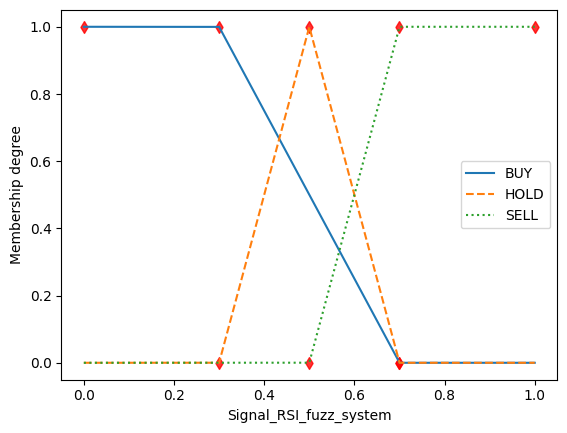

In [20]:
FS.plot_variable('Signal_RSI_fuzz_system')

dec_rsi
HOLD    4131
BUY      610
SELL     558
Name: count, dtype: int64